In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

import lightgbm as lgb

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import gc

In [113]:
df = pd.read_csv(r".\online_shoppers_intention.csv")

In [114]:
def missing_KNN_imputer (df, n_neig, metric):

    #Define imputer
    imputer = KNNImputer(n_neighbors=n_neig, metric=metric)

    #Find columns with NaN and apply Imputer
    df.loc[:, df.isnull().any()] = imputer.fit_transform(df.loc[:, df.isnull().any()])

    #Return dataframe
    return df

In [116]:
def cat_encoding (column):

    #List of unique values
    value_list = df[column].unique()

    #Creates a dict for encoding
    e_list = {}

    #Loop over all values in column and replace them with a number
    for count, value in enumerate(value_list):
        	e_list.update({value:count})
    df[column] = df[column].replace(e_list)
    
    #Returns altered column
    return df[column]


In [118]:
def replace_negative (column_list):

    #Loops over columns in column list and replaces -1 with 0
    for column in column_list:

        df[column] = df[column].replace(-1,0)

    return df

In [119]:
column_list = ["Administrative_Duration","Informational_Duration","ProductRelated_Duration"]
df = replace_negative(column_list)

df["Month"] = cat_encoding("Month")
df["VisitorType"] = cat_encoding("VisitorType")

df = missing_KNN_imputer(df, 10, "nan_euclidean")

gc.collect()

del column_list

In [120]:
#Def X and y
y = df["Revenue"]
X = df.drop("Revenue",axis=1)

gc.collect()

del df

In [121]:
#Train and test splits
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=22)
kf = StratifiedKFold(n_splits=5,random_state=33)

del X,y

In [122]:
#Hyperopt Bayersian Optimization
def objective(params):

    params = {'learning_rate': params['learning_rate'],
     'max_depth': int(params['max_depth']),
     'subsample': params['subsample'],
     'num_leaves': int(params['num_leaves'])}

    model = lgb.LGBMClassifier(**params)

    score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=StratifiedKFold()).mean()

    print("Accuracy {:.3f} params {}".format(score, params))

    return score

space = {
    "learning_rate" : hp.choice("learning_rate", np.arange(0.05,0.31,0.05)),
    "max_depth" : hp.choice("max_depth", np.arange(10,50,1,dtype=int)),
    "subsample" : hp.uniform("subsample",0.8,1),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

In [123]:
print("Hyperopt estimated optimum {}".format(best))

In [124]:
def lightgbm_model(X_train,y_train,X_test,cat_features,parms):

    test_pred = np.zeros(len(X_test))

    for train_index, test_index in kf.split(X_train,y_train):
        X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

        lgb_train = lgb.Dataset(X_cv_train,label = y_cv_train)
        lgb_test = lgb.Dataset(X_cv_test,label = y_cv_test)

        model = lgb.train(parms,train_set=lgb_train,num_boost_round=500,categorical_feature=cat_features,       valid_sets=lgb_test,verbose_eval=20, early_stopping_rounds=200)

        test_pred += model.predict(X_test,num_iteration=model.best_iteration)/5

    return test_pred

In [125]:
cat_features = ["SpecialDay",'Month','OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend']
parms = {"objective" : "binary",
        'learning_rate': 0.05,
        'max_depth': 18, 
        'num_leaves': 24, 
        'subsample': 0.91}

test_pred = lightgbm_model(X_train,y_train,X_test,cat_features,parms)

gc.collect()

del cat_features, parms

C:\Users\Public\Anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Browser', 'Month', 'OperatingSystems', 'Region', 'SpecialDay', 'TrafficType', 'VisitorType', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\Public\Anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Browser', 'Month', 'OperatingSystems', 'Region', 'SpecialDay', 'TrafficType', 'VisitorType', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
Training until validation scores don't improve for 200 rounds
[20]	valid_0's binary_logloss: 0.261292
[40]	valid_0's binary_logloss: 0.229025
[60]	valid_0's binary_logloss: 0.220449
[80]	valid_0's binary_logloss: 0.217201
[100]	valid_0's binary_logloss: 0.216107
[120]	valid_0's binary_logloss: 0.216248
[140]	valid_0's binary_l

168

In [126]:
accuracy_score(y_test,test_pred.round())

0.9051094890510949

In [127]:
f1_score(y_test,test_pred.round())

0.6666666666666666

In [128]:
conf = confusion_matrix(y_test,test_pred.round())
print(conf)

gc.collect()

[[1998   87]
 [ 147  234]]


60

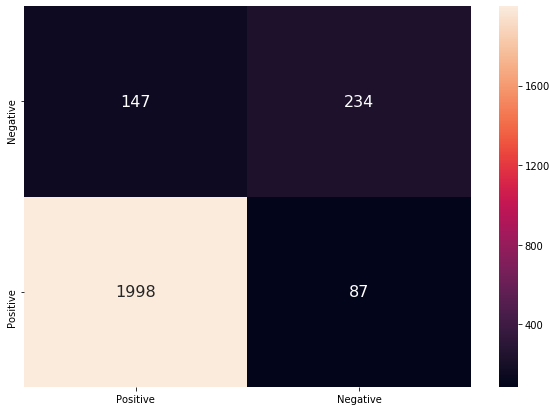

In [129]:
df_conf = pd.DataFrame(conf, index= ["Positive", "Negative"],
                        columns=["Positive", "Negative"])

ax, fig = plt.subplots(figsize=(10,7))

ax = sns.heatmap(df_conf, annot=True,annot_kws={"size": 16}, fmt="g")

bottom, top = plt.ylim()

ax.set_ylim(top - 0.5 , bottom + 0.5)

gc.collect()
del conf, df_conf, bottom, top